## EDA

Train Entity Counts: Counter({'Others': 3638, 'I-Versus': 105, 'B-person': 91, 'L-person': 91, 'B-Organization': 77, 'L-Organization': 77, 'B-Judges': 69, 'L-Judges': 69, 'I-Acts&Regulation': 22, 'B-Versus': 18, 'L-Versus': 18, 'B-Date': 15, 'I-Date': 15, 'L-Date': 15, 'B-Courts': 10, 'L-Courts': 10, 'I-Organization': 6, 'I-person': 5, 'I-Courts': 5, 'B-Acts&Regulation': 4, 'L-Acts&Regulation': 4, 'B-Location': 3, 'L-Location': 3, 'I-Judges': 2, 'I-Location': 1})
Valid Entity Counts: Counter({'Others': 679, 'B-Organization': 21, 'L-Organization': 21, 'B-person': 18, 'L-person': 18, 'B-Judges': 6, 'L-Judges': 6, 'B-Date': 1, 'I-Date': 1, 'L-Date': 1})
Test Entity Counts: Counter({'Others': 84, 'B-Organization': 5, 'L-Organization': 5})


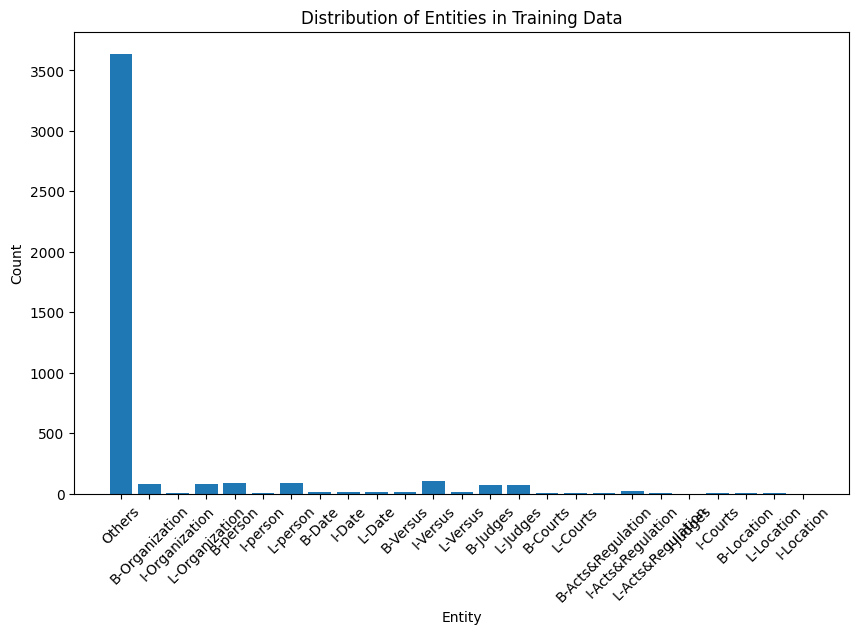

In [16]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# Function to extract entities and their counts
def extract_entities(file_path):
    entities = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.strip() and line.strip() != '-DOCSTART- -X- -X- O':
                parts = line.strip().split(' ')
                if len(parts) == 2:
                    entity = parts[1]
                    if entity != 'O':
                        entities.append(entity)
    return entities

# File paths for the training, validation, and test data
train_file_path = 'SmartSenseDL/data/datasets/legal_train.txt'
valid_file_path = 'SmartSenseDL/data/datasets/legal_valid.txt'
test_file_path = 'SmartSenseDL/data/datasets/legal_test.txt'

# Extract entities and their counts for each dataset
train_entities = extract_entities(train_file_path)
valid_entities = extract_entities(valid_file_path)
test_entities = extract_entities(test_file_path)

# Count the occurrences of each entity
train_entity_counts = Counter(train_entities)
valid_entity_counts = Counter(valid_entities)
test_entity_counts = Counter(test_entities)

# Print entity counts for each dataset
print('Train Entity Counts:', train_entity_counts)
print('Valid Entity Counts:', valid_entity_counts)
print('Test Entity Counts:', test_entity_counts)

# Plot the distribution of entities in the training data
plt.figure(figsize=(10, 6))
plt.bar(train_entity_counts.keys(), train_entity_counts.values())
plt.xlabel('Entity')
plt.ylabel('Count')
plt.title('Distribution of Entities in Training Data')
plt.xticks(rotation=45)
plt.show()


## Feature extraction

In [20]:
import spacy
from spacy.tokens import Doc, Span
from spacy.training import Example
from spacy import displacy

# Load the training data and preprocess it
def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data = []
    current_sentence = []
    for line in lines:
        line = line.strip()
        if line == '-DOCSTART- -X- -X- O' and current_sentence:
            data.append(current_sentence)
            current_sentence = []
        elif line:
            parts = line.split(' ')
            current_sentence.append((parts[0], parts[1]))
    if current_sentence:
        data.append(current_sentence)
    return data

train_data = load_data('SmartSenseDL/data/datasets/legal_train.txt')

# Define a function to convert data to spaCy format
def convert_to_spacy_format(data):
    spacy_data = []
    for sentence in data:
        words = [word for word, _ in sentence]
        entities = [(start, end, label) for start, end, label in get_entity_spans(sentence)]
        spacy_data.append(Example.from_dict(Doc(nlp.vocab, words=words), {"entities": entities}))
    return spacy_data

# Helper function to get entity spans
def get_entity_spans(sentence):
    entities = []
    start = None
    end = None
    label = None
    for i, (_, entity) in enumerate(sentence):
        if entity != 'O':
            if entity.startswith('B-'):
                if start is not None:
                    entities.append((start, end, label))
                start = i
                end = i + 1
                label = entity.split('-')[1]
            elif entity.startswith('I-') and start is not None:
                end = i + 1
            else:
                start = None
                end = None
                label = None
    if start is not None:
        entities.append((start, end, label))
    return entities

# Convert the data to spaCy format
train_spacy_data = convert_to_spacy_format(train_data)
